# Modeling Notebook

## Library Imports

In [ ]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path

In [2]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [3]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## 1. Data Access and Structure

### 1.1 Loading Cleaned Dataset

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

# get the dataset schema
schema = scan.collect_schema()

df = scan.collect()

In [5]:
# set feature and target variables
TARGET_LABEL = 'Label'
TARGET_FAMILY = 'Label_Family'
TARGET_BINARY = 'Label_Binary'

all_columns = schema.names()
target_columns = [TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]
feature_columns = [col for col in all_columns if col not in target_columns]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col not in target_columns]



## 2. Linear Model Assumptions & Preprocessing Design

### 2.1 Multicollinearity and Redundancy

### 2.2 Scaling Strategy for Numeric Features

### 2.3 Skewness and Transformations

### 2.4 Class Balance Profiling on Target Granularities

## 3. Stratified Equal-Sized Subsampling Strategy

### 3.1 Global Subsampling Parameters

In [6]:
def get_class_counts(lazy_scan: pl.LazyFrame, target_col: str) -> pl.DataFrame:
    """
    Return a Polars DataFrame with class counts for the given target column.
    Uses lazy scan -> group_by -> aggregate -> collect.
    """
    counts = (
        lazy_scan
        .group_by(target_col)
        .agg(pl.len().alias("count"))
        .collect()
        .sort("count")
    )
    return counts

# Get class counts for Label_Family
label_family_counts = get_class_counts(scan, TARGET_FAMILY)

print("\nLabel_Family (7/8-class) counts:")
print(label_family_counts)


Label_Family (7/8-class) counts:
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDOS         ┆ 12292078 │
└──────────────┴──────────┘


### 3.3 Subsampling for Label_Family (8 Classes)

In [7]:
# Desired per-class count
N_PER_CLASS_FAMILY = 10_000

# 1. Compute minimum available class size for safety
family_counts = (
    df.group_by(TARGET_FAMILY)
      .len()
      .rename({"len": "count"})
      .sort("count")
)

print("Label_Family class counts (ascending):")
print(family_counts)

min_family_class = family_counts["count"].min()

if N_PER_CLASS_FAMILY > min_family_class:
    print(f"\nRequested {N_PER_CLASS_FAMILY} per class, "
          f"but smallest family class has only {min_family_class}.")
    print(f"Using {min_family_class} per class instead.")
    N_PER_CLASS_FAMILY = min_family_class

print(f"\nFinal per-class sample size for Label_Family: {N_PER_CLASS_FAMILY}")

# 2. Memory-safe stratified sampling
family_subsample = (
    df
    .with_columns(
        pl.col(TARGET_FAMILY),
        pl.lit(0).alias("_dummy")
    )
    .with_columns(
        pl.col("_dummy").shuffle(seed=RANDOM_SEED).over(TARGET_FAMILY).alias("_rand")
    )
    .with_columns(
        pl.col("_rand").rank("ordinal").over(TARGET_FAMILY).alias("_rank")
    )
    .filter(pl.col("_rank") <= N_PER_CLASS_FAMILY)
    .drop(["_rand", "_rank", "_dummy"])
)

# 3. Shuffle final result so classes are mixed
family_subsample = family_subsample.sample(
    fraction=1.0,
    shuffle=True,
    seed=RANDOM_SEED
)

print("\nLabel_Family subsample shape:", family_subsample.shape)

# 4. Sanity check: each family class should have equal counts
family_subsample_counts = (
    family_subsample.group_by(TARGET_FAMILY)
                    .len()
                    .rename({"len": "count"})
                    .sort(TARGET_FAMILY)
)

family_subsample_counts

Label_Family class counts (ascending):
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDOS         ┆ 12292078 │
└──────────────┴──────────┘

Final per-class sample size for Label_Family: 10000

Label_Family subsample shape: (80000, 42)


Label_Family,count
str,u32
"""BENIGN""",10000
"""BRUTE_FORCE""",10000
"""DDOS""",10000
"""DOS""",10000
"""MIRAI""",10000
"""RECON""",10000
"""SPOOFING""",10000
"""WEB""",10000


## 4. Train/Test Split & Preprocessing Pipelines

### 4.4 Train/Test Split & Pipeline for 'Label_Family' (8 Classes)

In [8]:
# Feature matrix (drop all target columns)
X_family = family_subsample.drop([TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]).to_pandas()

# Target vector for Label_Family
y_family = family_subsample[TARGET_FAMILY].to_pandas()

# Perform stratified train/test split
X_train_family, X_test_family, y_train_family, y_test_family = train_test_split(
    X_family,
    y_family,
    test_size=0.2,          # 80/20 split
    stratify=y_family,
    random_state=RANDOM_SEED
)

print("Label_Family train:", X_train_family.shape, "Label_Family test:", X_test_family.shape)
print("Label_Family y-train class distribution:\n", y_train_family.value_counts().sort_index())
print("Label_Family y-test class distribution:\n", y_test_family.value_counts().sort_index())

Label_Family train: (64000, 39) Label_Family test: (16000, 39)
Label_Family y-train class distribution:
 Label_Family
BENIGN         8000
BRUTE_FORCE    8000
DDOS           8000
DOS            8000
MIRAI          8000
RECON          8000
SPOOFING       8000
WEB            8000
Name: count, dtype: int64
Label_Family y-test class distribution:
 Label_Family
BENIGN         2000
BRUTE_FORCE    2000
DDOS           2000
DOS            2000
MIRAI          2000
RECON          2000
SPOOFING       2000
WEB            2000
Name: count, dtype: int64


## 5. Multiclass Logistic Regression Models

### 5.1 Model configuration and Hyperparameters

In [9]:
# column groups
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

# numeric preprocessing: scale
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# categorical preprocessing: one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# combine them
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### 5.3 Logistic Regression for 'Label_Family' (8 Classes)

c:\Users\graha\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression — Label_Family (8-class) ===
Accuracy:  0.6229
Precision (macro): 0.6371
Recall (macro):    0.6229
F1-score (macro):  0.6222
Saved figure to ..\Images\Logistic_Regression_Confusion_Matrix_Label_Family.png


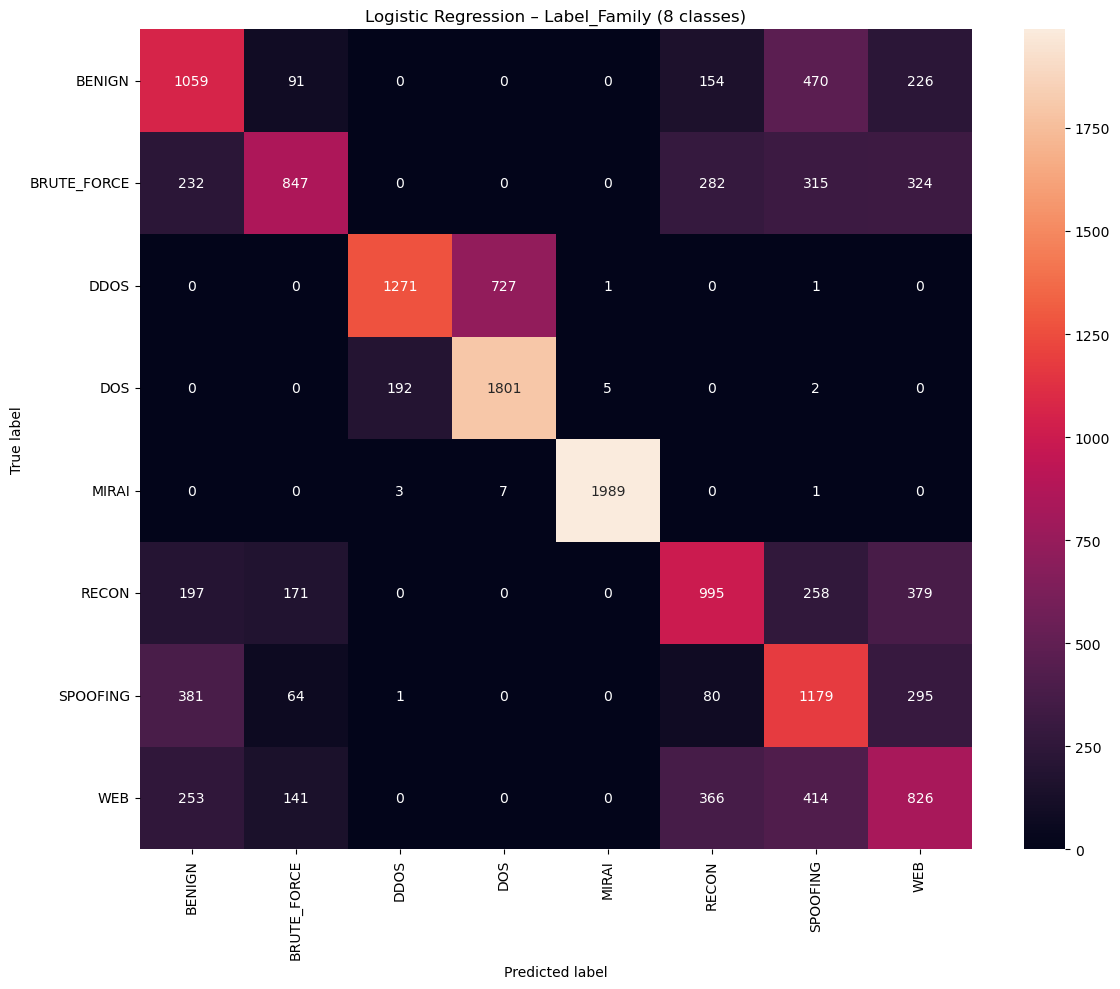

In [10]:
# build pipeline
logreg_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=500,
            n_jobs=-1
        ))
    ]
)

# fit/train
logreg_family_pipeline.fit(X_train_family, y_train_family)

# predict
family_pred = logreg_family_pipeline.predict(X_test_family)

# metrics
family_accuracy = accuracy_score(y_test_family, family_pred)
family_precision = precision_score(y_test_family, family_pred, average="macro", zero_division=0)
family_recall = recall_score(y_test_family, family_pred, average="macro", zero_division=0)
family_f1 = f1_score(y_test_family, family_pred, average="macro", zero_division=0)

print("=== Logistic Regression — Label_Family (8-class) ===")
print(f"Accuracy:  {family_accuracy:.4f}")
print(f"Precision (macro): {family_precision:.4f}")
print(f"Recall (macro):    {family_recall:.4f}")
print(f"F1-score (macro):  {family_f1:.4f}")

# confusion matrix
cm_family = confusion_matrix(y_test_family, family_pred, labels=logreg_family_pipeline.classes_)

# use the class labels on the axes
fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_family,
    annot=True,
    fmt="d",
    xticklabels=logreg_family_pipeline.classes_,
    yticklabels=logreg_family_pipeline.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression – Label_Family (8 classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# save figure
save_figure(fig, "Logistic_Regression_Confusion_Matrix_Label_Family.png")
plt.show()

Saved figure to ..\Images\Logistic_Regression_ROC_OvR_Label_Family.png


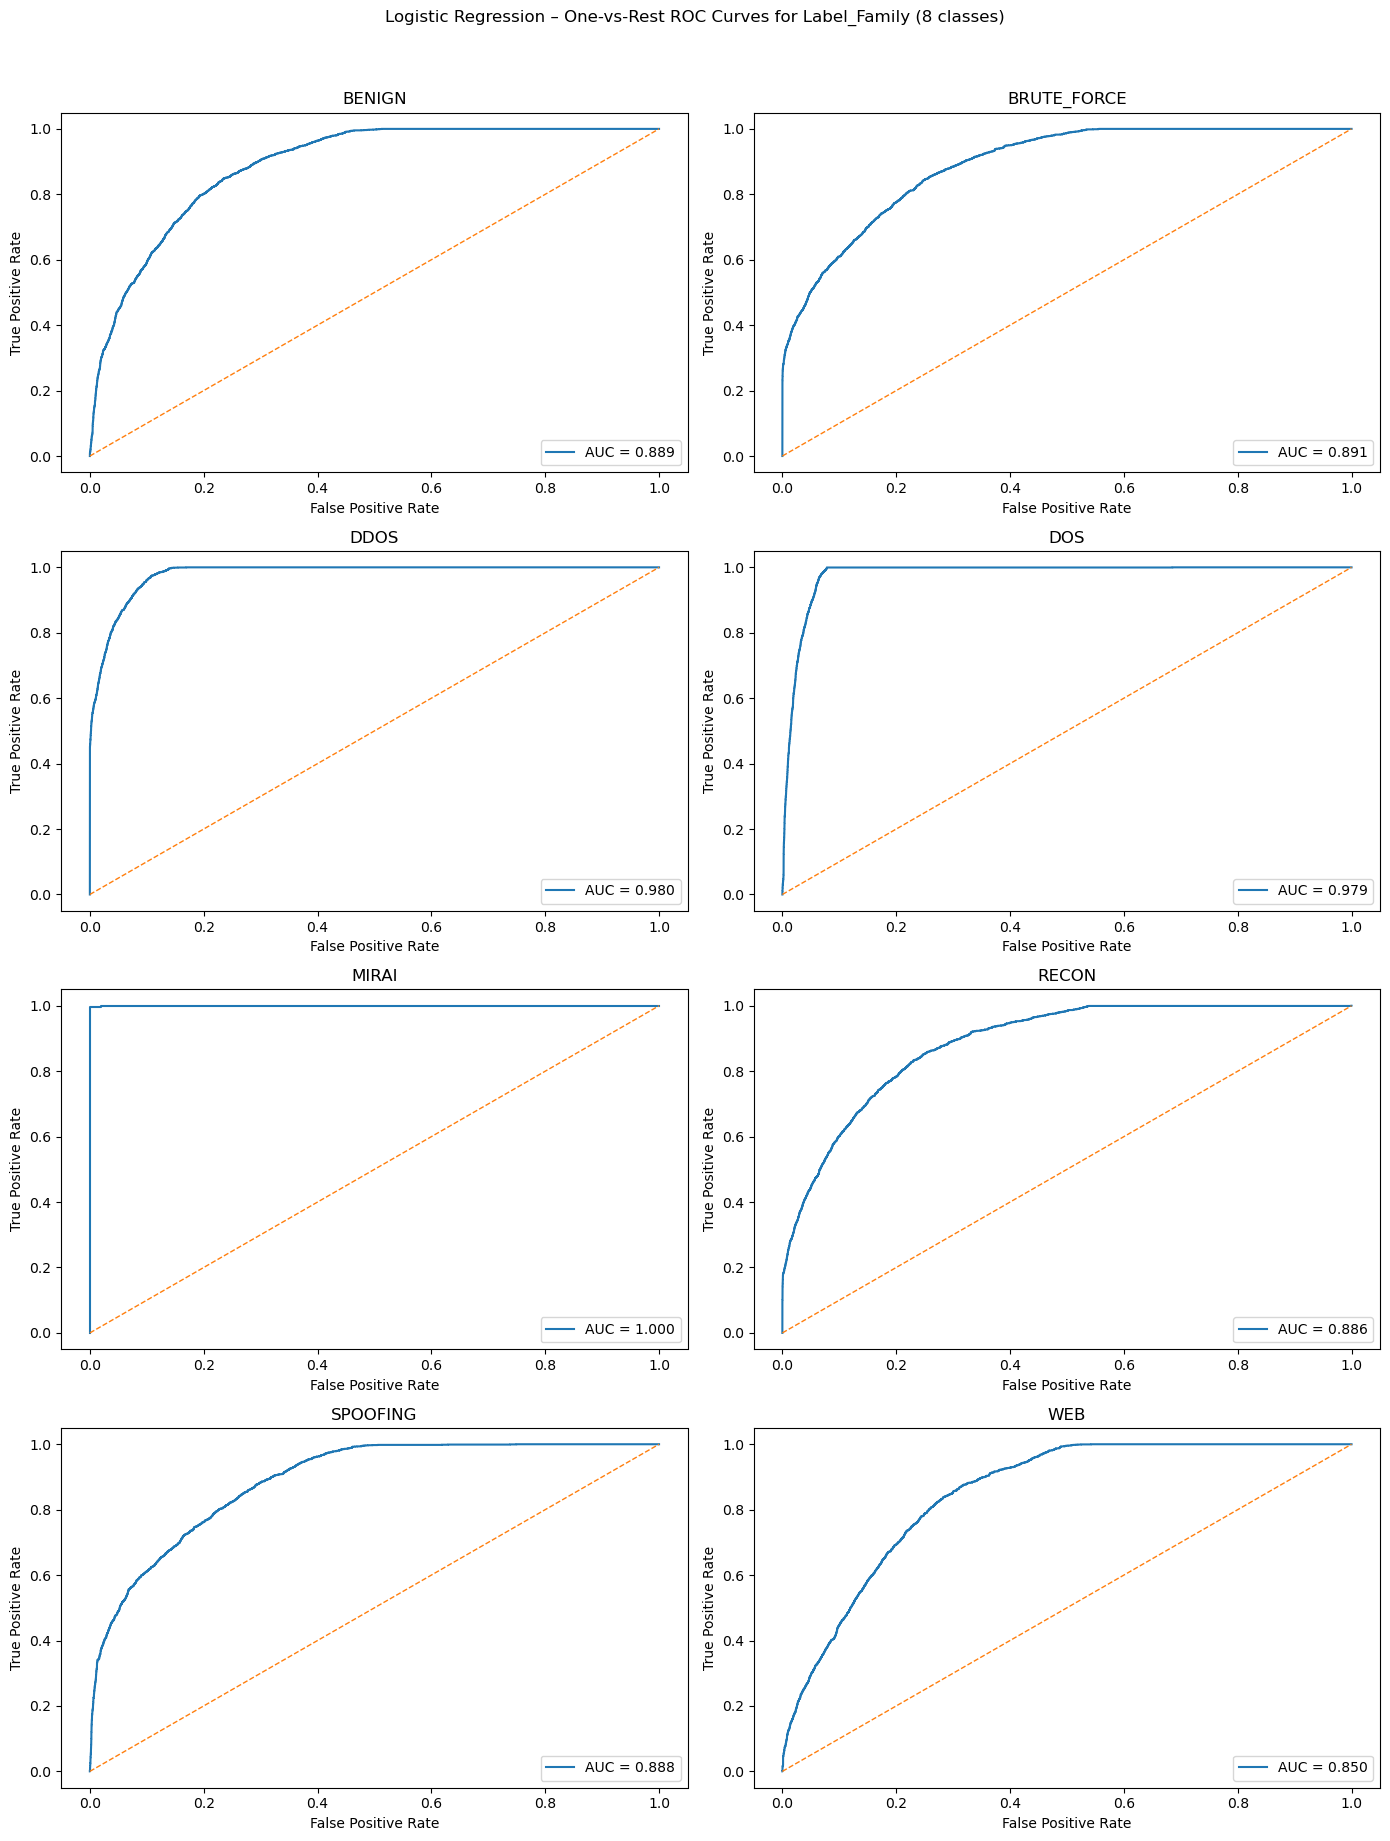

Macro-average AUC (OvR) for Label_Family: 0.9203


In [11]:
# --- One-vs-Rest ROC Curves for Logistic Regression, Label_Family (8 classes) ---

# get predicted probabilities for each class
y_score_family = logreg_family_pipeline.predict_proba(X_test_family)

# class names (these are your 7 attack families + benign => 8 total)
class_names_family = logreg_family_pipeline.classes_
n_classes_family = len(class_names_family)

# binarize the true labels: shape (n_samples, n_classes)
y_test_family_bin = label_binarize(y_test_family, classes=class_names_family)

# create a grid of subplots (facet-like view): 4 rows x 2 columns for 8 classes
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))

roc_aucs_family = []

for idx, class_name in enumerate(class_names_family):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]

    # one-vs-rest ROC for this class
    fpr, tpr, _ = roc_curve(y_test_family_bin[:, idx], y_score_family[:, idx])
    roc_auc = auc(fpr, tpr)
    roc_aucs_family.append(roc_auc)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title(f"{class_name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

# overall title and layout
fig.suptitle(
    "Logistic Regression – One-vs-Rest ROC Curves for Label_Family (8 classes)",
    y=1.02
)
plt.tight_layout()

# save the figure with your helper
save_figure(fig, "Logistic_Regression_ROC_OvR_Label_Family.png")

plt.show()

# print macro-average AUC across the 8 classes
macro_auc_family = np.mean(roc_aucs_family)
print(f"Macro-average AUC (OvR) for Label_Family: {macro_auc_family:.4f}")

In [ ]:
# SHAP visualizations for Logistic Regression, Label_Family (8 classes)

## 6. Linear Support Vector Machine Models

### 6.3 Linear SVM for 'Label_Family' (8 Classes)

=== Linear SVM — Label_Family (7-class) ===
Accuracy:  0.6179
Precision (macro): 0.6457
Recall (macro):    0.6179
F1-score (macro):  0.6170
Saved figure to ..\Images\Linear_SVM_Label_Family_Confusion_Matrix.png


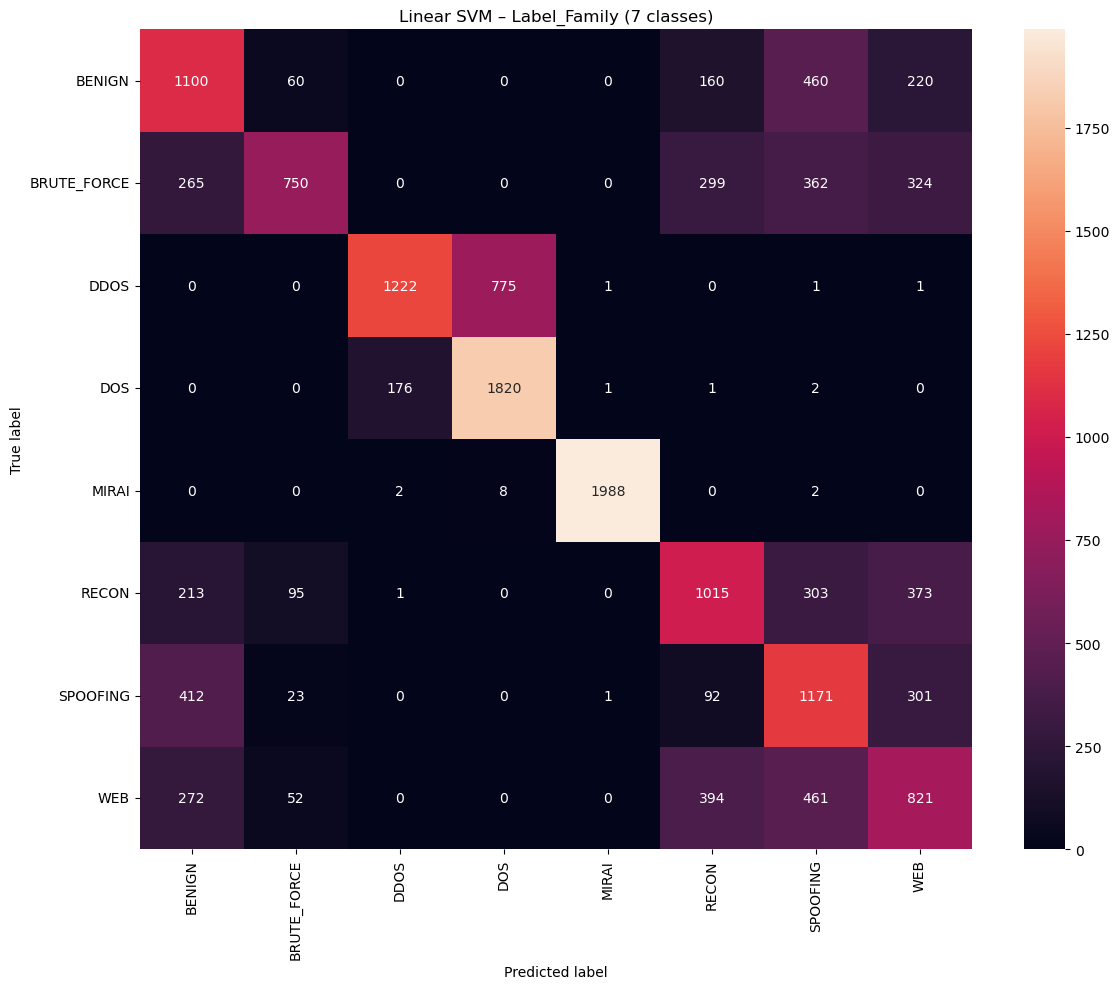

In [ ]:
# linear SVM pipeline for Label_Family
linearsvc_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearSVC(
            C=1.0,
            max_iter=5000,
            dual=False    # recommended for high-dimensional, more samples than features
        ))
    ]
)

# fit/train
linearsvc_family_pipeline.fit(X_train_family, y_train_family)

# predict
family_svm_pred = linearsvc_family_pipeline.predict(X_test_family)

# metrics
family_svm_accuracy = accuracy_score(y_test_family, family_svm_pred)
family_svm_precision = precision_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_recall = recall_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_f1 = f1_score(y_test_family, family_svm_pred, average="macro", zero_division=0)

print("=== Linear SVM — Label_Family (7-class) ===")
print(f"Accuracy:  {family_svm_accuracy:.4f}")
print(f"Precision (macro): {family_svm_precision:.4f}")
print(f"Recall (macro):    {family_svm_recall:.4f}")
print(f"F1-score (macro):  {family_svm_f1:.4f}")

# confusion matrix
cm_family_svm = confusion_matrix(y_test_family, family_svm_pred, labels=linearsvc_family_pipeline.classes_)

# use the class labels on the axes
fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_family_svm,
    annot=True,
    fmt="d",
    xticklabels=linearsvc_family_pipeline.classes_,
    yticklabels=linearsvc_family_pipeline.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Linear SVM – Label_Family (7 classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# save figure with helper function
save_figure(fig, "Linear_SVM_Label_Family_Confusion_Matrix.png")
plt.show()

Saved figure to ..\Images\LinearSVM_Label_Family_OvR_ROC.png


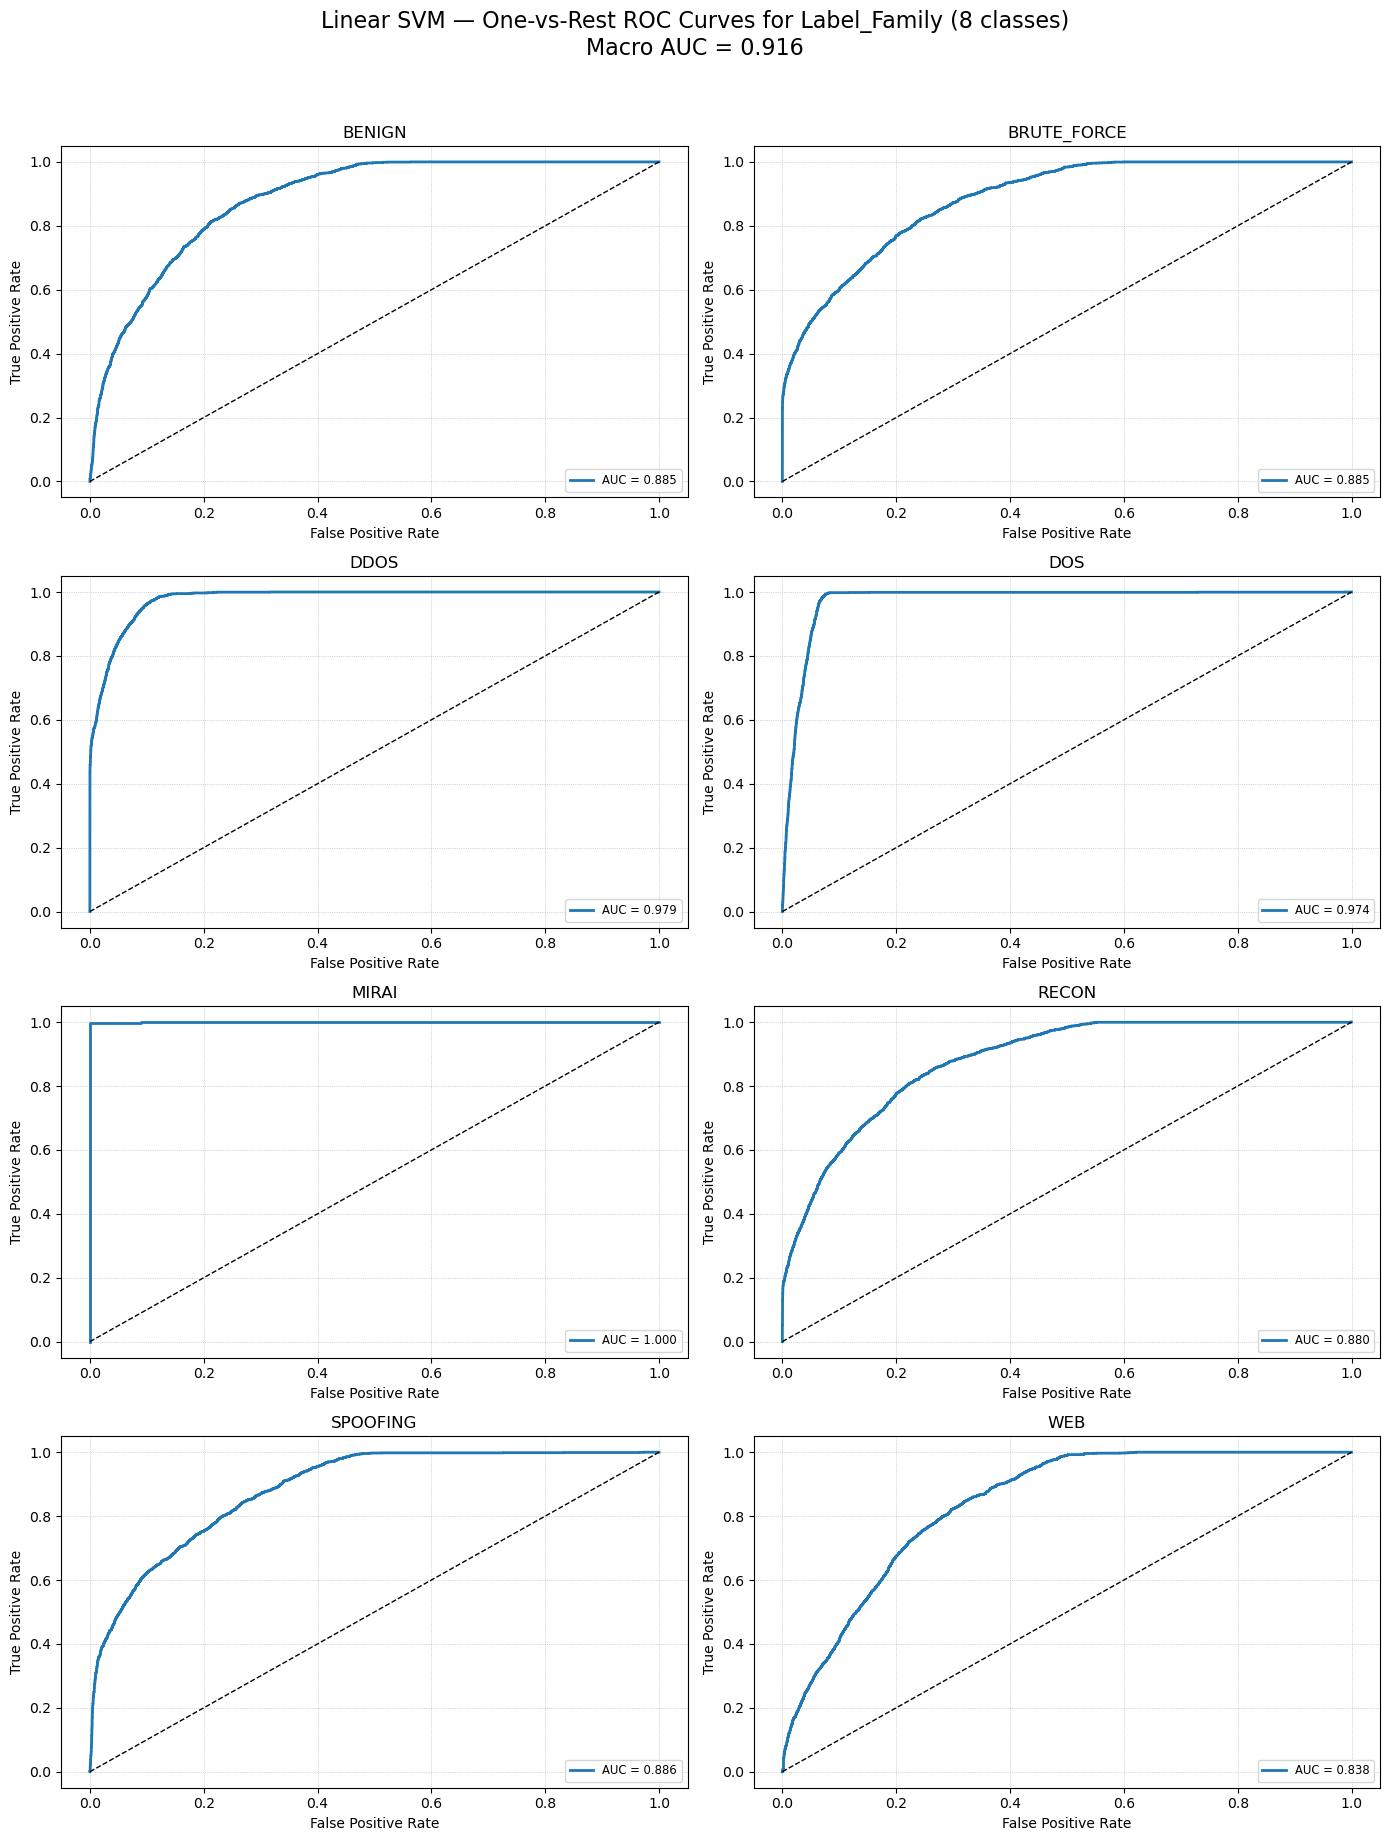

In [ ]:
# compute decision scores for each class (OvR-compatible)
y_score_family_svm = linearsvc_family_pipeline.decision_function(X_test_family)

# extract class names in correct order
family_classes_svm = linearsvc_family_pipeline.classes_
n_classes_svm = len(family_classes_svm)

# binarize y_test for OvR
y_test_family_bin_svm = label_binarize(y_test_family, classes=family_classes_svm)

# prepare subplot grid: 4 rows × 2 columns for 8 classes
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))

svm_roc_aucs = []

for idx, cls in enumerate(family_classes_svm):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]

    # Get FPR/TPR
    fpr, tpr, _ = roc_curve(
        y_test_family_bin_svm[:, idx],
        y_score_family_svm[:, idx]
    )
    roc_auc = auc(fpr, tpr)
    svm_roc_aucs.append(roc_auc)

    ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_title(f"{cls}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize="small")
    ax.grid(True, linestyle=":", linewidth=0.5)

# macro-average AUC across all 8 classes
macro_auc_svm = np.mean(svm_roc_aucs)

fig.suptitle(
    f"Linear SVM — One-vs-Rest ROC Curves for Label_Family (8 classes)\nMacro AUC = {macro_auc_svm:.3f}",
    y=1.02,
    fontsize=16
)
plt.tight_layout()
# save with helper
save_figure(fig, "LinearSVM_Label_Family_OvR_ROC.png")
plt.show()

## 7. Cross Model and Cross Granularity Comparisons

### 7.1 Summary Table of Metrics

In [ ]:
# Results Summary Tables

# combined Table: All Models
# -----------------------------

combined_results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Target": "Label_Family (8-class)",
        "Accuracy": family_accuracy,
        "Precision": family_precision,
        "Recall": family_recall,
        "F1": family_f1
    },
    {
        "Model": "Linear SVM",
        "Target": "Label_Family (8-class)",
        "Accuracy": family_svm_accuracy,
        "Precision": family_svm_precision,
        "Recall": family_svm_recall,
        "F1": family_svm_f1
    }
])

print("=== Combined Results Table ===")
display(combined_results)
# save table
save_table(combined_results, "Linear_Combined_Results.csv")


# separate Table: Label_Family (8-class)
# -----------------------------

family_results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": family_accuracy,
        "Precision": family_precision,
        "Recall": family_recall,
        "F1": family_f1
    },
    {
        "Model": "Linear SVM",
        "Accuracy": family_svm_accuracy,
        "Precision": family_svm_precision,
        "Recall": family_svm_recall,
        "F1": family_svm_f1
    }
])

print("=== Label_Family (8-class) Results ===")
display(family_results)
# save table
save_table(family_results, "Linear_Label_Family_Results.csv")


### 7.2 Discussion of Results